In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Load Necessary libraries

In [2]:
from __future__ import print_function
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import numpy as np
from torchsummary import summary

In [3]:
import warnings
warnings.simplefilter("ignore")
warnings.warn("deprecated", DeprecationWarning)
warnings.filterwarnings( "ignore", module = "matplotlib\..*" )

In [4]:
!pip install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 18.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.4.8-py3-none-any.whl size=38247 sha256=92d08b8042857ac31e7cdc04dc12189c9f2668bc8ea6ab327c0c646cf0f29d3f
  Stored in directory: /root/.cache/pip/wheels/f8/04/36/94ff3c8a4215826a21946b34c01180817e606989fdf53f7cd6
Successfully built grad-cam


In [5]:
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

In [ ]:
# SEED = 1

# # CUDA?
# cuda = torch.cuda.is_available()
# print("CUDA Available?", cuda)

# # For reproducibility
# torch.manual_seed(SEED)

# if cuda:
#     torch.cuda.manual_seed(SEED)

Load all the modules

In [6]:
!cp /content/drive/MyDrive/The\ School\ of\ AI/Session\ 11\ Assignment/dataload.py /content
!cp /content/drive/MyDrive/The\ School\ of\ AI/Session\ 11\ Assignment/models/resnet.py /content
!cp /content/drive/MyDrive/The\ School\ of\ AI/Session\ 11\ Assignment/run.py /content
!cp /content/drive/MyDrive/The\ School\ of\ AI/Session\ 11\ Assignment/utils.py /content

In [8]:
import dataload
import resnet
import run
import utils

from dataload import Draw, AlbumentationImageDataset, args, loader
from resnet import *
from run import Performance, scores, train, test
from utils import allot_device, Plots, plot_metrics, printTrainTest_LossAcc, get_misclassified_data, display_gradcam_output

In [9]:
train_loader,test_loader = loader.load_data(512)
print(len(train_loader),len(test_loader))

100%|██████████| 170498071/170498071 [00:01<00:00, 103855230.96it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
98 20


<Figure size 640x480 with 0 Axes>

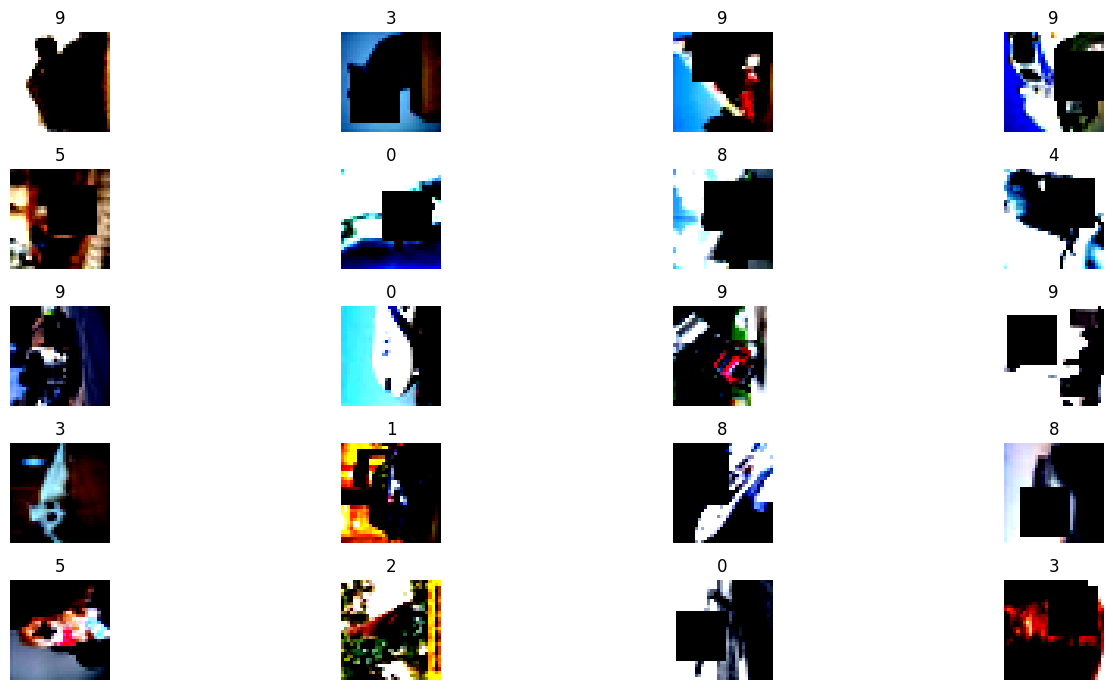

In [10]:
#train_data
Plots(None,21,train_loader).plot_images()

<Figure size 640x480 with 0 Axes>

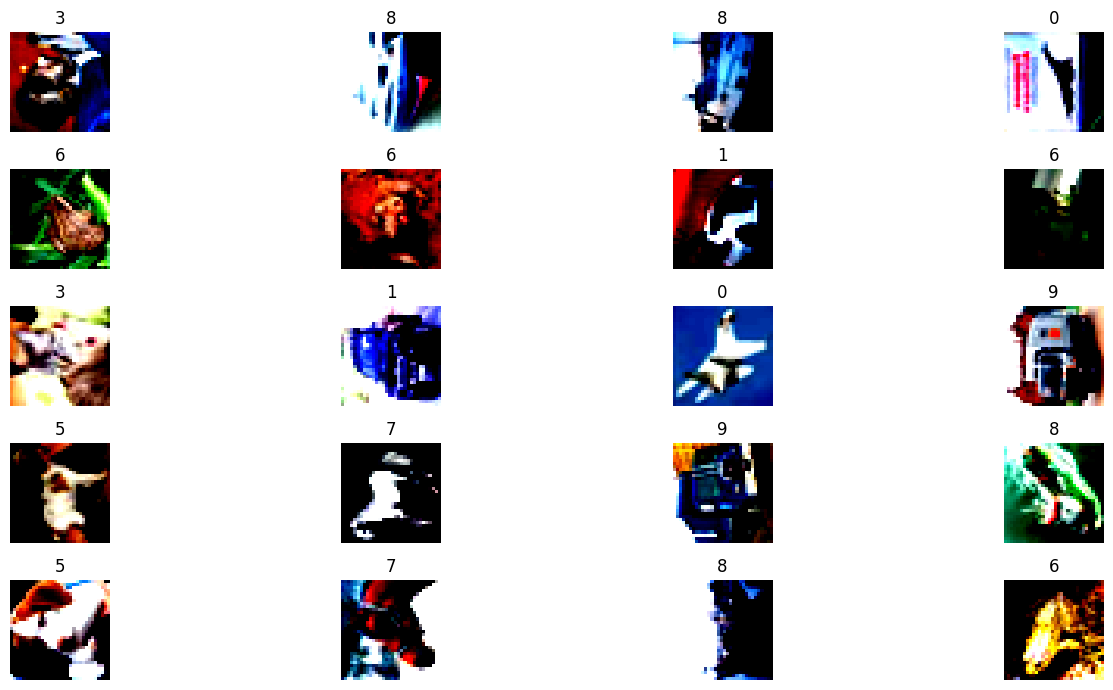

In [11]:
#test_data
Plots(None,21,test_loader).plot_images()

In [12]:
 # Setting up the device
device = allot_device(142)
print(f"{device} is available")

cuda is available


In [14]:
model = ResNet18().to(device)

return_summary(model,device,(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

In [11]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=

In [15]:
!pip install torch_lr_finder

In [16]:
from torch_lr_finder import LRFinder

  0%|          | 0/200 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 4.65E-02


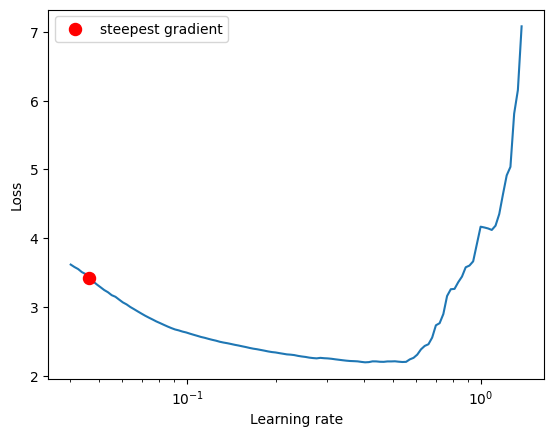

In [17]:
model = ResNet18().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.03, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(train_loader, end_lr=10, num_iter=200, step_mode="exp")
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state

In [18]:
from torch.optim.lr_scheduler import OneCycleLR

EPOCHS = 20

scheduler = OneCycleLR(
        optimizer,
        max_lr=4.65E-02,
        steps_per_epoch=len(train_loader),
        epochs=EPOCHS,
        pct_start=5/EPOCHS,
        div_factor=100,
        three_phase=False,
        final_div_factor=100,
        anneal_strategy='linear'
    )
criterion = nn.CrossEntropyLoss()
#perf = Performance(device,model,(train_loader,test_loader),optimizer,criterion,[False,0.01])

for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train_losses, train_acc = train(model, device, train_loader, optimizer, epoch, criterion,scheduler)
    test_losses, test_acc = test(model, device, test_loader, criterion)
    #scheduler.step()

EPOCH: 0


Loss=1.443795919418335 Batch_id=97 Accuracy=40.72: 100%|██████████| 98/98 [00:47<00:00,  2.06it/s]



Test set: Average loss: 0.0034, Accuracy: 4495/10000 (44.95%)

EPOCH: 1


Loss=1.070478081703186 Batch_id=97 Accuracy=54.09: 100%|██████████| 98/98 [00:47<00:00,  2.07it/s]



Test set: Average loss: 0.0026, Accuracy: 5435/10000 (54.35%)

EPOCH: 2


Loss=1.0924404859542847 Batch_id=97 Accuracy=61.42: 100%|██████████| 98/98 [00:47<00:00,  2.05it/s]



Test set: Average loss: 0.0023, Accuracy: 5724/10000 (57.24%)

EPOCH: 3


Loss=1.0394442081451416 Batch_id=97 Accuracy=64.67: 100%|██████████| 98/98 [00:48<00:00,  2.04it/s]



Test set: Average loss: 0.0032, Accuracy: 4918/10000 (49.18%)

EPOCH: 4


Loss=1.0073888301849365 Batch_id=97 Accuracy=65.47: 100%|██████████| 98/98 [00:48<00:00,  2.03it/s]



Test set: Average loss: 0.0029, Accuracy: 5390/10000 (53.90%)

EPOCH: 5


Loss=0.9959067106246948 Batch_id=97 Accuracy=66.70: 100%|██████████| 98/98 [00:48<00:00,  2.03it/s]



Test set: Average loss: 0.0070, Accuracy: 3268/10000 (32.68%)

EPOCH: 6


Loss=0.9752622246742249 Batch_id=97 Accuracy=68.21: 100%|██████████| 98/98 [00:48<00:00,  2.03it/s]



Test set: Average loss: 0.0022, Accuracy: 6274/10000 (62.74%)

EPOCH: 7


Loss=0.8198164701461792 Batch_id=97 Accuracy=69.75: 100%|██████████| 98/98 [00:48<00:00,  2.03it/s]



Test set: Average loss: 0.0031, Accuracy: 4786/10000 (47.86%)

EPOCH: 8


Loss=0.9363976716995239 Batch_id=97 Accuracy=70.68: 100%|██████████| 98/98 [00:48<00:00,  2.03it/s]



Test set: Average loss: 0.0021, Accuracy: 6555/10000 (65.55%)

EPOCH: 9


Loss=0.7700924873352051 Batch_id=97 Accuracy=71.75: 100%|██████████| 98/98 [00:47<00:00,  2.04it/s]



Test set: Average loss: 0.0017, Accuracy: 6908/10000 (69.08%)

EPOCH: 10


Loss=0.7694172859191895 Batch_id=97 Accuracy=73.21: 100%|██████████| 98/98 [00:47<00:00,  2.05it/s]



Test set: Average loss: 0.0054, Accuracy: 4057/10000 (40.57%)

EPOCH: 11


Loss=0.7734352350234985 Batch_id=97 Accuracy=73.67: 100%|██████████| 98/98 [00:47<00:00,  2.07it/s]



Test set: Average loss: 0.0022, Accuracy: 6401/10000 (64.01%)

EPOCH: 12


Loss=0.7692586779594421 Batch_id=97 Accuracy=75.21: 100%|██████████| 98/98 [00:47<00:00,  2.08it/s]



Test set: Average loss: 0.0018, Accuracy: 7010/10000 (70.10%)

EPOCH: 13


Loss=0.6577988862991333 Batch_id=97 Accuracy=76.53: 100%|██████████| 98/98 [00:47<00:00,  2.06it/s]



Test set: Average loss: 0.0018, Accuracy: 6997/10000 (69.97%)

EPOCH: 14


Loss=0.6499742269515991 Batch_id=97 Accuracy=77.71: 100%|██████████| 98/98 [00:47<00:00,  2.06it/s]



Test set: Average loss: 0.0014, Accuracy: 7631/10000 (76.31%)

EPOCH: 15


Loss=0.6303618550300598 Batch_id=97 Accuracy=78.83: 100%|██████████| 98/98 [00:47<00:00,  2.06it/s]



Test set: Average loss: 0.0014, Accuracy: 7620/10000 (76.20%)

EPOCH: 16


Loss=0.5255942344665527 Batch_id=97 Accuracy=80.80: 100%|██████████| 98/98 [00:47<00:00,  2.06it/s]



Test set: Average loss: 0.0012, Accuracy: 7852/10000 (78.52%)

EPOCH: 17


Loss=0.4715038537979126 Batch_id=97 Accuracy=82.59: 100%|██████████| 98/98 [00:47<00:00,  2.07it/s]



Test set: Average loss: 0.0010, Accuracy: 8314/10000 (83.14%)

EPOCH: 18


Loss=0.49002328515052795 Batch_id=97 Accuracy=84.28: 100%|██████████| 98/98 [00:47<00:00,  2.07it/s]



Test set: Average loss: 0.0008, Accuracy: 8638/10000 (86.38%)

EPOCH: 19


Loss=0.3106793761253357 Batch_id=97 Accuracy=87.21: 100%|██████████| 98/98 [00:47<00:00,  2.06it/s]



Test set: Average loss: 0.0007, Accuracy: 8770/10000 (87.70%)



In [32]:
torch.save(model, '/content/drive/MyDrive/The School of AI/Session 11 Assignment/model.pt')

In [13]:
model = torch.load('/content/drive/MyDrive/The School of AI/Session 11 Assignment/model.pt')

In [19]:
type(test_losses[0])

float

In [20]:
train_losses_new = torch.stack(train_losses).cpu().detach().numpy()
train_acc_new = torch.tensor(train_acc, device = 'cpu')
test_losses_new = torch.tensor(test_losses, device = 'cpu')
test_acc_new = torch.tensor(test_acc, device = 'cpu')

In [21]:
type(train_losses_new)

numpy.ndarray

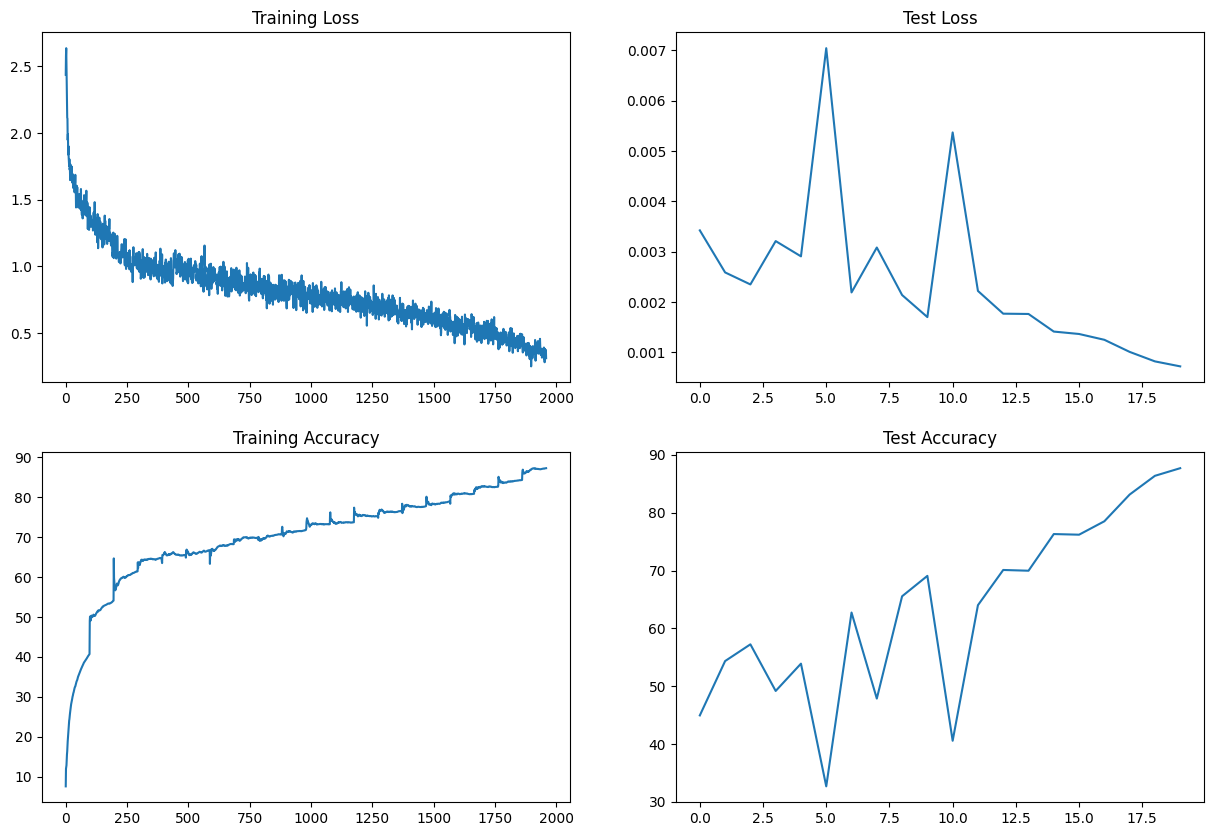

In [22]:
printTrainTest_LossAcc(train_losses_new, train_acc_new, test_losses_new,test_acc_new)

In [14]:
import matplotlib.pyplot as plt

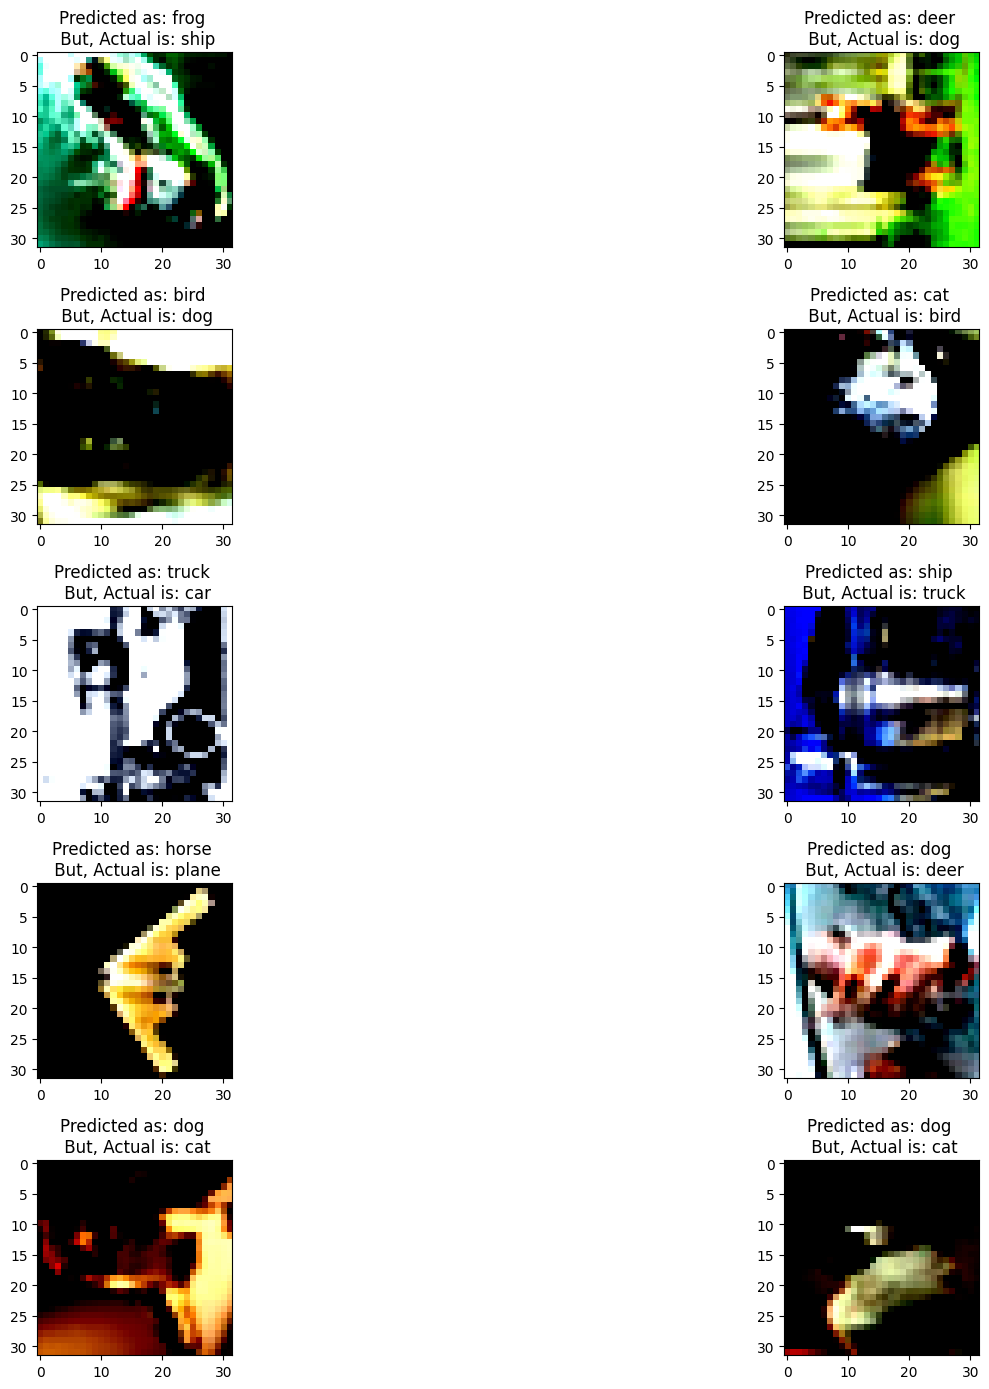

In [15]:
Plots((model,test_loader,device,10)).mis_classified()

In [17]:
# Denormalize the data using test mean and std deviation
inv_normalize = transforms.Normalize(
    mean=[-0.50/0.23, -0.50/0.23, -0.50/0.23],
    std=[1/0.23, 1/0.23, 1/0.23]
)

In [18]:
# Get the misclassified data from test dataset
misclassified_data = get_misclassified_data(model, device, test_loader)

In [19]:
type(misclassified_data)

list

In [21]:
classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

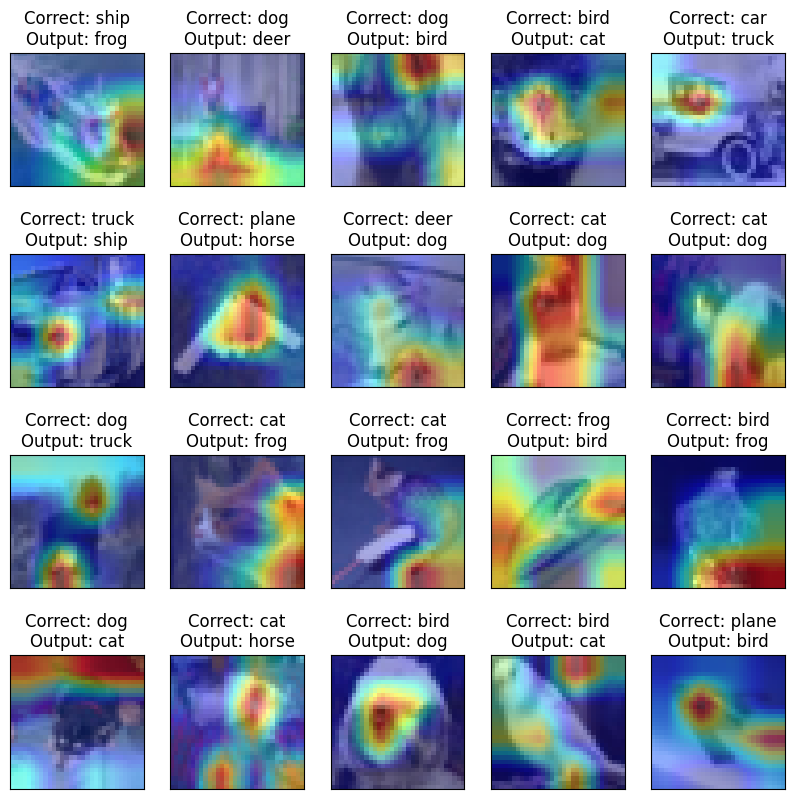

In [26]:
target_layers = [model.layer4[-1]]
# targets = [ClassifierOutputTarget(7)]
targets = None

display_gradcam_output(misclassified_data, classes, inv_normalize, model, target_layers, targets, number_of_samples=20, transparency=0.60)

Try on the second last layer

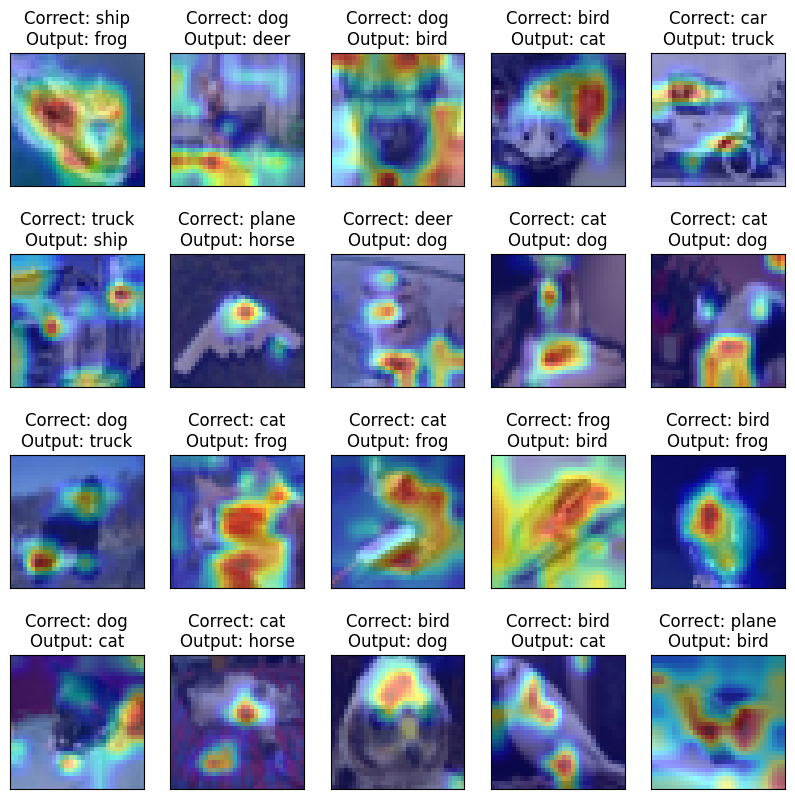

In [28]:
target_layers = [model.layer3[-2]]
# targets = [ClassifierOutputTarget(7)]
targets = None

display_gradcam_output(misclassified_data, classes, inv_normalize, model, target_layers, targets, number_of_samples=20, transparency=0.60)